In [182]:
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os

# stuff to deal with the words
import nltk
from nltk.stem import WordNetLemmatizer

In [ ]:
# nltk might complain

# nltk.download('wordnet')
# nltk.download('punkt')

In [97]:
# read in the data
df = pd.read_json('./recipies.json')

In [98]:
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


# Try to deal with the text data

So the models aren't going to be able to deal with the textual data. We'll need to encode everything into numerical values so we can feed them into some sort of a model. 

The real issue is the ingredient list. It doesn't easily encode using something like a one-hot encoder. I did some googling, and people suggest using TF-IDF to encode the string. We'll see how that goes... 

In [111]:
# encode the cuisines into numerical values

encoder = preprocessing.LabelEncoder() #encoder for cuisine
cuisine_enc = encoder.fit_transform(df['cuisine'])

df['cuisine_enc'] = cuisine_enc

In [112]:
encoder.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [8]:
vectorizer = TfidfVectorizer(binary=True)

In [9]:
X = vectorizer.fit_transform(df['ingredients'])

In [18]:
print(vectorizer.get_feature_names())

['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'all', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'an', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'and', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'any', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic', 'arepa', 'argo', 'ar

From looking at the feature names, there are a lot of repeated words or almost repeated words... like "bananas" and "banana". There also seem to be some misspellings, but I'm not sure how I am going to deal with that. 

After some googling... to remove the "bananas" and "banana" we need to "lemmatize" the words. 

I'd really like to lemmatize the words and then use the whole phrase as a feature. I dunno how to do that.


After some more googling... we are going to use `nltk` to do the lemmatizing.

# Lemmatize the words

In [116]:
l = [[' '.join([WordNetLemmatizer().lemmatize(w).lower() for w in words.split()]) for words in lists] for lists in df['ingredients']]

In [117]:
l[0]

['romaine lettuce',
 'black olive',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese crumbles']

In [118]:
df['ingredients_lemma'] = l

In [119]:
df

,id,cuisine,ingredients,cuisine_enc,ingredients_lemma
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6,"[romaine lettuce, black olive, grape tomato, g..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16,"[plain flour, ground pepper, salt, tomato, gro..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4,"[egg, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",7,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7,"[black pepper, shallot, cornflour, cayenne pep..."
...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",8,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",9,"[kraft zesty italian dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",8,"[egg, citrus fruit, raisin, sourdough starter,..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",3,"[boneless chicken skinless thigh, minced garli..."


# Train-Test Split

At this point we need to do some splitting. We only want to do the feature engineering on the training data. We'll then apply it to the testing data, but we don't want to make decisions with knowledge about the test data.

Would be nice to use sklearn but we'll do it outselves. 80% training 20% testing

In [122]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

# Feature Engineering. 

So there are a ton of different ingredients... We are going to focus on only a few to get us going. Let's focus on the ingredients that show up the most often. If it only appears 1-2 times, then it's not going to give us very much predictive power. 

In [123]:
# Feature engineering
print("Selecting ingredients for features...")
recipe = np.array(df_train['ingredients_lemma'].values)
ingredients_dict = {}
for i in range(0, len(recipe)):
    for word in recipe[i][:]:
        try:
            ingredients_dict[word] += 1
        except:
            ingredients_dict[word] = 1

Selecting ingredients for features...


In [85]:
ingredients_dict

{'romaine lettuce': 65,
 'black olive': 59,
 'grape tomato': 65,
 'garlic': 1830,
 'pepper': 1138,
 'purple onion': 467,
 'seasoning': 42,
 'garbanzo bean': 43,
 'feta cheese crumbles': 94,
 'plain flour': 41,
 'ground pepper': 101,
 'salt': 4559,
 'tomato': 752,
 'ground black pepper': 1235,
 'thyme': 87,
 'egg': 901,
 'green tomato': 31,
 'yellow corn meal': 90,
 'milk': 599,
 'vegetable oil': 1098,
 'mayonaise': 170,
 'cooking oil': 141,
 'green chilies': 192,
 'grilled chicken breast': 1,
 'garlic powder': 404,
 'yellow onion': 303,
 'soy sauce': 822,
 'butter': 1229,
 'chicken liver': 16,
 'water': 1805,
 'wheat': 6,
 'black pepper': 640,
 'shallot': 370,
 'cornflour': 29,
 'cayenne pepper': 392,
 'onion': 1955,
 'garlic paste': 60,
 'lemon juice': 364,
 'chili powder': 478,
 'passata': 7,
 'oil': 484,
 'ground cumin': 669,
 'boneless chicken skinless thigh': 80,
 'garam masala': 222,
 'double cream': 12,
 'natural yogurt': 2,
 'bay leaf': 458,
 'sugar': 1640,
 'fresh ginger root'

In [124]:
# order them from most frequent to less frequent
ingredients_dict1 = sorted(ingredients_dict.items(), key = lambda x:x[1], reverse=True)

In [150]:
ingredients_dict1 = dict(ingredients_dict1)

In [142]:
# select the max number of features, and the features that have at least N < num < M number of appearances.
maxFeatures = 1000
lim = [50, 15000]
selectedIngredients = [item for item in ingredients_dict if lim[0] <= ingredients_dict[item] <= lim[1]]
selectedIngredients = selectedIngredients[:maxFeatures]

In [147]:
selectedIngredients[:25]

['romaine lettuce',
 'black olive',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese crumbles',
 'plain flour',
 'ground pepper',
 'salt',
 'tomato',
 'ground black pepper',
 'thyme',
 'egg',
 'green tomato',
 'yellow corn meal',
 'milk',
 'vegetable oil',
 'mayonaise',
 'cooking oil',
 'green chilies',
 'garlic powder',
 'yellow onion']

# Create the Feature Matrix... 

This is where we are building all the encoded features into our training and testing matrices.

In [176]:
def getFeatureArray(itemlist,featureList,featureArray):
    for item in itemlist:
        if item in featureList:
            featureArray[item] = 1
    return featureArray

def create_feature_matrix(df, selectedIngredients, numFeatures=None):
    print("Constructing feature matrix...")
    if not numFeatures:
        numFeatures = len(selectedIngredients)
    
    featureMatrix = np.zeros((len(df.index), numFeatures), dtype=int)

    # Construct a featureMatrix containing the feature info of all the entries in dataframe
    i = 0
    for index, row in df.iterrows():
        itemList = set(row['ingredients_lemma'])
        featureMatrix[i,:] = getFeatureArray(itemList, selectedIngredients, pd.Series(0, index=selectedIngredients))
        i += 1
    
    return featureMatrix

In [175]:
featureMatrix_train = create_feature_matrix(df_train, selectedIngredients)
featureMatrix_test = create_feature_matrix(df_test, selectedIngredients)

Constructing feature matrix...
Constructing feature matrix...


In [177]:
featureMatrix_train

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [208]:
featureMatrix_train.shape

(31914, 864)

# Train the model

Gonna use a random forst model because I like them and we have all these catagorical features

In [178]:
from sklearn.ensemble import RandomForestClassifier

In [180]:
forest = RandomForestClassifier(n_estimators=100)

model = forest.fit(featureMatrix_train, df_train.cuisine_enc.values.reshape(-1, 1))


/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [181]:
predictions = model.predict(featureMatrix_test)

In [184]:
print(classification_report(df_test.cuisine_enc.values, predictions))

              precision    recall  f1-score   support

           0       0.72      0.36      0.48       106
           1       0.43      0.21      0.28       154
           2       0.79      0.61      0.69       300
           3       0.71      0.84      0.77       536
           4       0.57      0.47      0.52       145
           5       0.54      0.49      0.51       545
           6       0.75      0.53      0.62       233
           7       0.76      0.86      0.81       625
           8       0.54      0.26      0.35       129
           9       0.71      0.87      0.78      1492
          10       0.78      0.39      0.52       102
          11       0.67      0.58      0.62       274
          12       0.76      0.54      0.63       167
          13       0.80      0.89      0.84      1273
          14       0.70      0.50      0.58       145
          15       0.64      0.29      0.40        93
          16       0.60      0.72      0.66       883
          17       0.62    

In [199]:
%matplotlib notebook
from sklearn import metrics


<IPython.core.display.Javascript object>


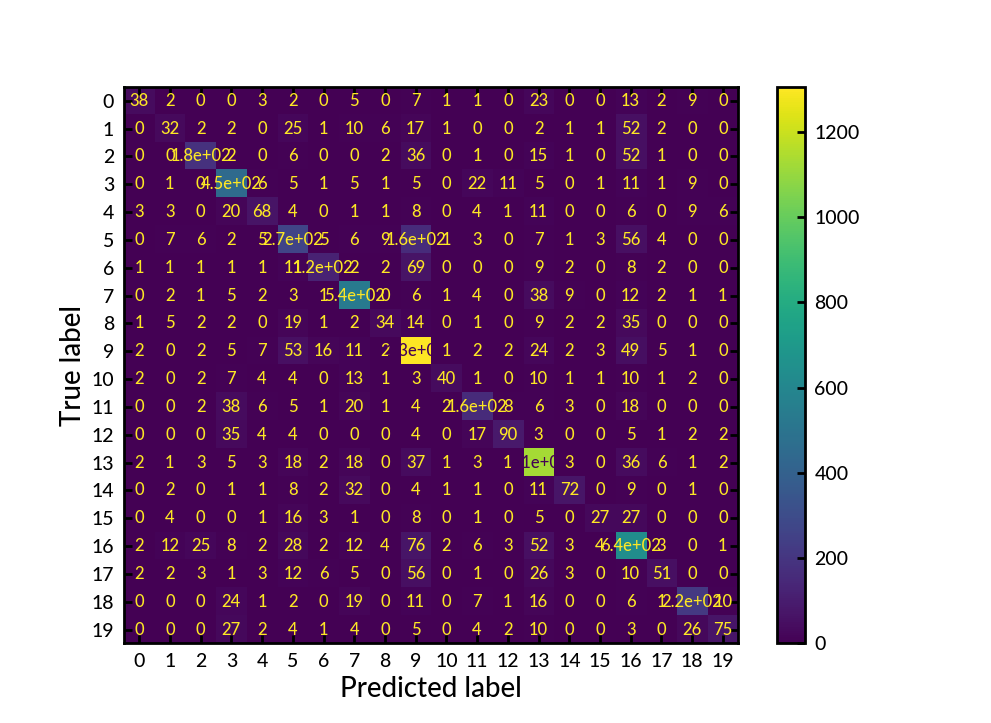

In [200]:
metrics.plot_confusion_matrix(model, featureMatrix_test, df_test.cuisine_enc.values)

In [201]:
df_train.head(10)

,id,cuisine,ingredients,cuisine_enc,ingredients_lemma
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6,"[romaine lettuce, black olive, grape tomato, g..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16,"[plain flour, ground pepper, salt, tomato, gro..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4,"[egg, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",7,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7,"[black pepper, shallot, cornflour, cayenne pep..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...",10,"[plain flour, sugar, butter, egg, fresh ginger..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...",17,"[olive oil, salt, medium shrimp, pepper, garli..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...",9,"[sugar, pistachio nut, white almond bark, flou..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...",13,"[olive oil, purple onion, fresh pineapple, por..."
10,5875,italian,"[pimentos, sweet pepper, dried oregano, olive ...",9,"[pimento, sweet pepper, dried oregano, olive o..."


In [204]:
encoder.classes_[6]

'greek'